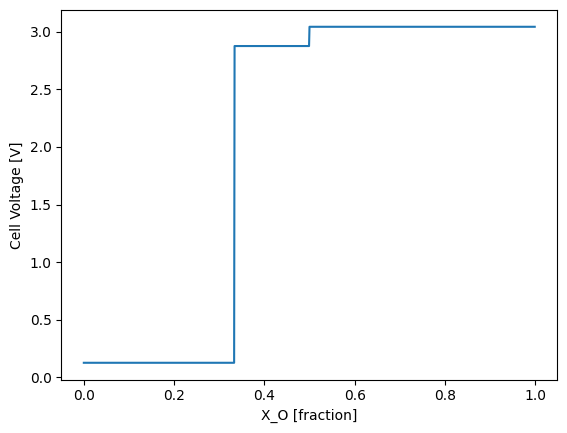

In [1]:
from pycalphad import Workspace, variables as v
from pycalphad.property_framework import JanssonDerivative
from typing import Dict, List
import numpy.typing as npt

class CellVoltageProperty:
    implementation_units = 'volt'
    display_units = 'volt'
    display_name = 'Cell Voltage'

    def __init__(self, species: v.Species, num_electrons=1):
        self.species = v.Species(species)
        self.num_electrons = num_electrons

    def compute_property(self, compsets: List["CompositionSet"], cur_conds: Dict[str, float], chemical_potentials: npt.ArrayLike) -> npt.ArrayLike:
        mu_li = v.MU(self.species).compute_property(compsets, cur_conds, chemical_potentials)
        return -mu_li / (self.num_electrons * 9.64853321e4)

    # Only needed if the property should support differentiation
    def jansson_derivative(self, compsets: List["CompositionSet"], cur_conds: Dict[str, float], chemical_potentials: npt.ArrayLike,
                           deltas: "JanssonDerivativeDeltas") -> npt.ArrayLike:
        # Derivative implementation is easy here since cell voltage is directly related to MU
        mu_li_grad = v.MU(self.species).jansson_derivative(compsets, cur_conds, chemical_potentials, deltas)
        return -mu_li_grad / (self.num_electrons * 9.64853321e4)

    @property
    def shape(self):
        return tuple()

CellVoltage = CellVoltageProperty('LI', num_electrons=1)

wks = Workspace('Li_O.tdb', ['LI', 'O', 'VA'])
wks.conditions = {v.X('O'): (1e-6, 1, 0.001), v.T: 400., v.P: 1e5, v.N: 1}

wks.plot(v.X('O'), CellVoltage)

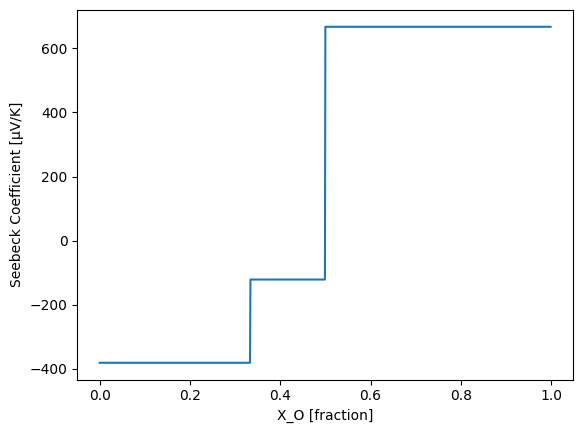

In [2]:
# Flip the sign of voltage (by convention) for Seebeck coefficient
class NegativeCellVoltageProperty(CellVoltageProperty):
    def compute_property(self, *args):
        return -super().compute_property(*args)
    def jansson_derivative(self, *args):
        return -super().jansson_derivative(*args)

vt = JanssonDerivative(NegativeCellVoltageProperty('LI', 1), v.T)['uV/K']
vt.display_name = 'Seebeck Coefficient'
wks.plot(v.X('O'), vt)